In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Load the dataset
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

# Initial data exploration
print(train_data.head())
print(train_data.info())
print(train_data.describe())
print(train_data.isnull().sum())


   id  CustomerId    Surname  CreditScore Geography  Gender   Age  Tenure  \
0   0  15643359.0   Chidubem        605.0    France    Male  29.0     5.0   
1   1  15624703.0  Okechukwu        700.0    France    Male  37.0     4.0   
2   2  15583392.0      Okeke        572.0    France    Male  49.0     2.0   
3   3  15594878.0    Yobanna        813.0   Germany    Male  31.0     8.0   
4   4  15792669.0     Ch'ang        670.0    France  Female  38.0     7.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00            1.0        1.0             1.0        151623.91   
1  115301.31            2.0        1.0             1.0        162501.83   
2   62610.96            1.0        1.0             1.0        142514.69   
3  134591.35            1.0        0.0             0.0         90591.15   
4       0.00            1.0        1.0             0.0        148528.24   

   Exited  
0     0.0  
1     0.0  
2     1.0  
3     0.0  
4     0.0  
<class 'pandas

In [3]:
# Drop unnecessary columns
train_data = train_data.drop(columns=['CustomerId', 'Surname'])
test_data_with_id = test_data.copy()
test_data = test_data.drop(columns=['CustomerId', 'Surname'])

# Encode categorical variables
le = LabelEncoder()
train_data['Gender'] = le.fit_transform(train_data['Gender'])
test_data['Gender'] = le.transform(test_data['Gender'])

# One-hot encode Geography
train_data = pd.get_dummies(train_data, columns=['Geography'])
test_data = pd.get_dummies(test_data, columns=['Geography'])

# Ensure test data has the same columns as train data
missing_cols = set(train_data.columns) - set(test_data.columns)
for c in missing_cols:
    test_data[c] = 0
test_data = test_data[train_data.columns.drop('Exited')]

# Scale features
scaler = StandardScaler()
features_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
train_data[features_to_scale] = scaler.fit_transform(train_data[features_to_scale])
test_data[features_to_scale] = scaler.transform(test_data[features_to_scale])

In [4]:
# Split data into train and validation sets
X = train_data.drop(columns=['Exited'])
y = train_data['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

XGBoost Validation AUC: 0.9241906136170089
CatBoost Validation AUC: 0.9358700658358983
[LightGBM] [Info] Number of positive: 2465, number of negative: 9535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205417 -> initscore=-1.352777
[LightGBM] [Info] Start training from score -1.352777
LightGBM Validation AUC: 0.9354659492162409


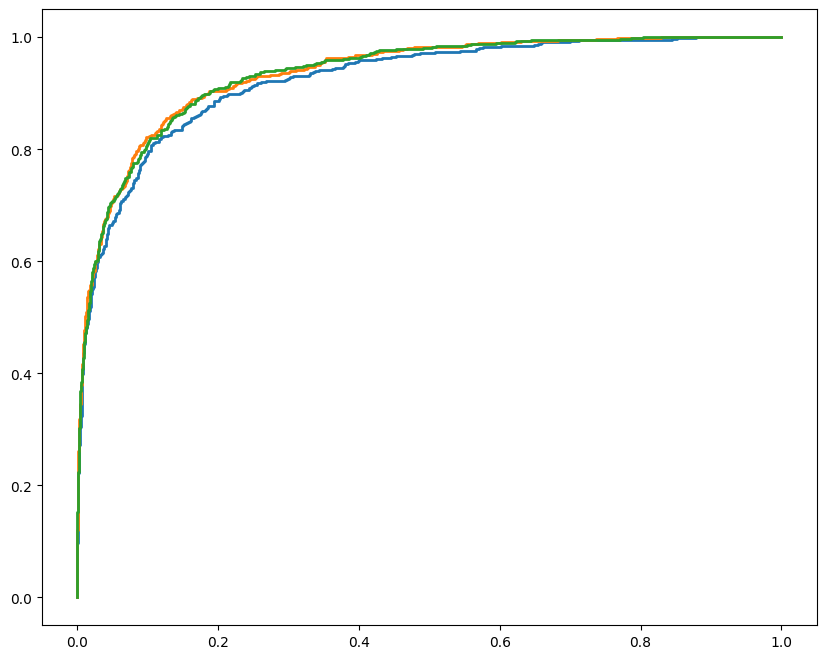

In [15]:
# Train basic models
xgb_model = xgb.XGBClassifier(random_state=42)
cb_model = cb.CatBoostClassifier(random_seed=42, verbose=0)
lgb_model = lgb.LGBMClassifier(random_state=42)

models = {
    'XGBoost': xgb_model,
    'CatBoost': cb_model,
    'LightGBM': lgb_model
}

auc_scores = {}

# Function to plot ROC curve
def plot_roc_curve(y_val, y_val_prob, model_name, linestyle='-', lw=2):
    fpr, tpr, _ = roc_curve(y_val, y_val_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, linestyle=linestyle, label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_val_prob = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_prob)
    auc_scores[model_name] = auc_score
    print(f"{model_name} Validation AUC: {auc_score}")
    plot_roc_curve(y_val, y_val_prob, model_name)



In [16]:
# Identify the best model
best_model_name = max(auc_scores, key=auc_scores.get)
best_model = models[best_model_name]

print(f"The best model is: {best_model_name}")

# Hyperparameter tuning for the best model (CatBoost in my case)
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7]
}

grid = GridSearchCV(best_model, param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)
tuned_model = grid.best_estimator_

# Evaluate the tuned model
y_val_prob_tuned = tuned_model.predict_proba(X_val)[:, 1]
auc_score_tuned = roc_auc_score(y_val, y_val_prob_tuned)
print(f"{best_model_name} Validation AUC after hyperparameter tuning: {auc_score_tuned:.4f}")


The best model is: CatBoost
CatBoost Validation AUC after hyperparameter tuning: 0.9399


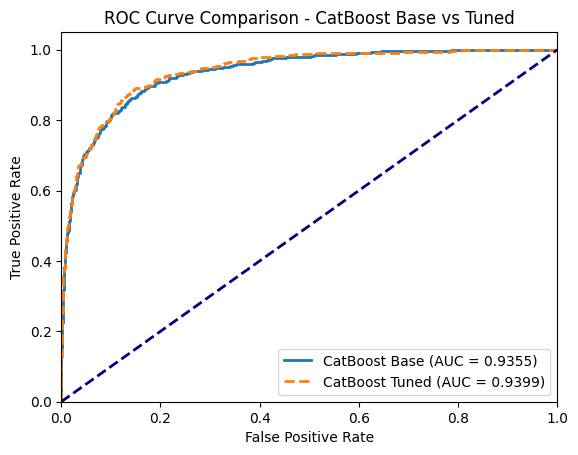

In [17]:
# Plot ROC curve comparison
plt.figure()
plot_roc_curve(y_val, y_val_prob, f'{best_model_name} Base', linestyle='-', lw=2)
plot_roc_curve(y_val, y_val_prob_tuned, f'{best_model_name} Tuned', linestyle='--', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve Comparison - {best_model_name} Base vs Tuned')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Save the tuned model
tuned_model.save_model('models/final_model_tuned.cbm')

# Predict on test data
test_prob = tuned_model.predict_proba(test_data)[:, 1]

# Prepare submission
submission = pd.DataFrame({
    'CustomerId': test_data_with_id['CustomerId'],
    'Exited': test_prob
})

submission.to_csv('submission.csv', index=False)


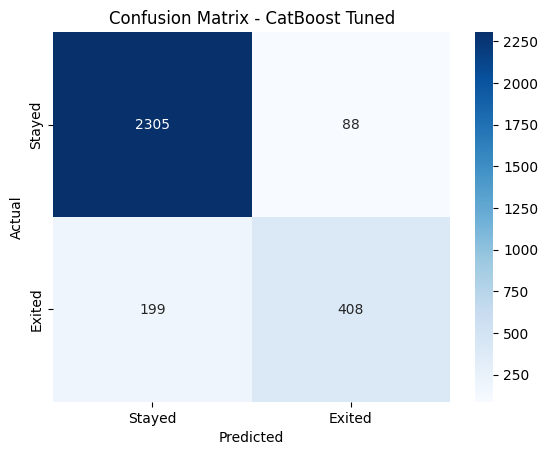

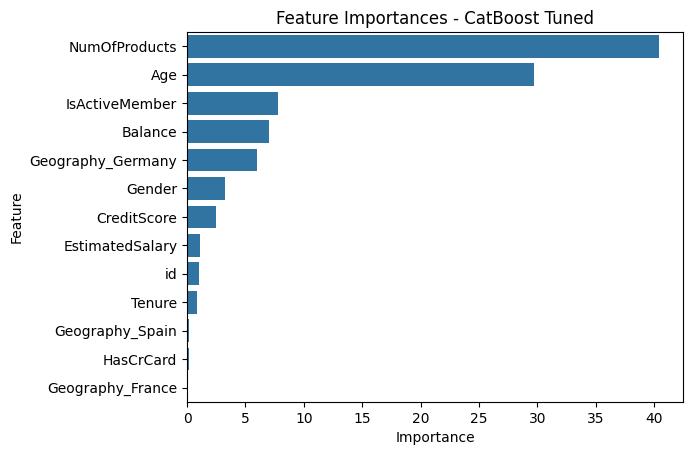

In [20]:
# Confusion matrix for the tuned model
y_val_pred_tuned = tuned_model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Exited'], yticklabels=['Stayed', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name} Tuned')
plt.show()

# Analysis of feature importance for the tuned model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': tuned_model.get_feature_importance()
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title(f'Feature Importances - {best_model_name} Tuned')
plt.show()